# Workflows

For now we mainly looked at models in isolation. However, the true power of probabilistic modelling lies in its ability to move beyond the "one-model-fits-all" idea, but rather create a variety of models and connect or compare them in various ways. Indeed, even for a normal use cases, we already typically go up to a dozen models or more. In more complex experimental designs, which are becoming every more common, this can easily go up to a hundred or more.

In [183]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Even in relatively simple use cases, managing different models, storing them across sessions, and let them depend on each other can be a pain. To make this easier, we created a small workflow manager in the `laflow` package. It borrows elements from other workflow managers such as snakemake or nextflow. However, it is much more focused on interactivity, modularization and model inheritance that, all concepts very central to the modelling we're doing here.

The core tasks of laflow is:
- **Persistence**, to store sure models and its derivatives on disk
- **Model inheritance**, creation of similar models that only differ in certain aspects
- **Connecting data**, to explicitely define what a model needs and where it gets this

In [211]:
import laflow as laf

We'll use the same dataset as [before](./1-variables).

In [212]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata

## Persistence

::::{margin}
:::{note}
In the tutorials, we will always work from a temporary directory. In a real situation, the root directory will be typically your project's root directory or one of its subdirectories.
:::
::::

In [213]:
import tempfile
import pathlib
project_root = pathlib.Path(tempfile.TemporaryDirectory().name)
project_root.mkdir()
laf.set_project_root(project_root) # sets the default project root

The basis of laflow is the {class}`laflow.Flow` class. Each instance we create is associated with a particular folder on disk, starting from a given root directory.

In [214]:
dataset = laf.Flow("dataset")
dataset.path

PosixPath('/tmp/tmpzawf8pcm/dataset')

This folder will store information on each object, links to other objects or flows, and the objects themselves if they are labeled as persistent. We can easily store an object inside a flow by simply assigning it:

In [188]:
dataset.adata = adata

Because python objects are by default persistent, the `adata` object was saved in the folder as a pickle. Along with it is a info json file which is used internally to keep track which type of object it is and how it was created.

In [189]:
!ls -lh {dataset.path}

total 6.4M
-rw-r--r-- 1 wsaelens updepla  156 Oct  3 19:59 adata.info
-rw-r--r-- 1 wsaelens updepla 6.4M Oct  3 19:59 adata.pkl


When working in IPython environments (e.g. Jupyter), we can always check what contents a flow object has as follows:

In [190]:
dataset

Even if we restart our session (simulated here by removing the flow object), we can always retrieve it by recreating a flow object in the correct folder:

In [191]:
if "dataset" in globals():
    del dataset
dataset = laf.Flow("dataset")

In [192]:
dataset

## Modularization

To make our workflows more modular, we use Python's OOP system to systematically let certain flows depend on each other and share common code. For example, a dataset in our example would be defined as follows:

In [193]:
class Dataset(laf.Flow):
    default_name = "dataset"
    adata = laf.PyObj()

We can initialize this dataset as before. Note that we do not provide a name in this case as we want to use the default "dataset" name:

In [194]:
dataset = Dataset()

In [195]:
dataset

We can now define our model as another Flow. It contains a link to the dataset flow, along with three methods that create, infer and interpret the model: 

In [196]:
class ConstantModel(laf.Flow):
    default_name = "constant"
    
    dataset = laf.FlowObj()
    
    root_initial = laf.LatentaObj(persistent = False)
    
    root = laf.LatentaObj()
    
    def create_root_initial(self, adata):
        overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")
        transcriptome = lac.transcriptome.Transcriptome.from_adata(dataset.adata)
        foldchange = transcriptome.find("foldchange")

        foldchange.overexpression = la.links.scalar.Constant(overexpression, definition=foldchange.value_definition)
        
        return transcriptome, 
        
    def infer_model(self, root_initial):
        root = root_initial.clone()
        with root.switch(la.config.device):
            inference = la.infer.svi.SVI(
                root, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
            )
            trainer = la.infer.trainer.Trainer(inference)
            trace = trainer.train(10000)
            
        return root, 
    
    transcriptome_observed = laf.LatentaObj()
    overexpression_observed = laf.LatentaObj()
    overexpression_causal = laf.LatentaObj()
            
    def interpret(self, root):
        transcriptome_observed = la.posterior.vector.VectorObserved(root)
        transcriptome_observed.sample(5)
        
        overexpression = root.find("overexpression")
        
        overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
        overexpression_observed.sample(5)
        
        overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
            overexpression, root, interpretable = root.p.mu.expression, observed = overexpression_observed
        )
        overexpression_causal.sample(10)
        overexpression_causal.sample_random(10)
        overexpression_causal.observed
        overexpression_causal.sample_empirical()
        
        return transcriptome_observed, overexpression_observed, overexpression_causal

In [197]:
model = ConstantModel()

In [198]:
model

In [199]:
model.dataset = dataset

In [200]:
model

In [201]:
model.dataset

In [202]:
model.root_initial,  = model.create_root_initial(model.dataset.adata)

In [203]:
model

In [204]:
model.root, = model.infer_model(model.root_initial)

  0%|                                                                                                         …

In [205]:
model.transcriptome_observed, model.overexpression_observed, model.overexpression_causal = model.interpret(model.root)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/tmppluw9g_b/constant/root.pkl: 559.2 KiB / 11.2 MiB = 0.049, 0:02


In [206]:
model

/tmp/tmppluw9g_b/constant/transcriptome_observed.pkl: 3,177.5 KiB / 24.7 MiB = 0.126, 6.2 MiB/s, 0:04
/tmp/tmppluw9g_b/constant/overexpression_causal.pkl: 3,618.5 KiB / 40.6 MiB = 0.087, 10 MiB/s, 0:03


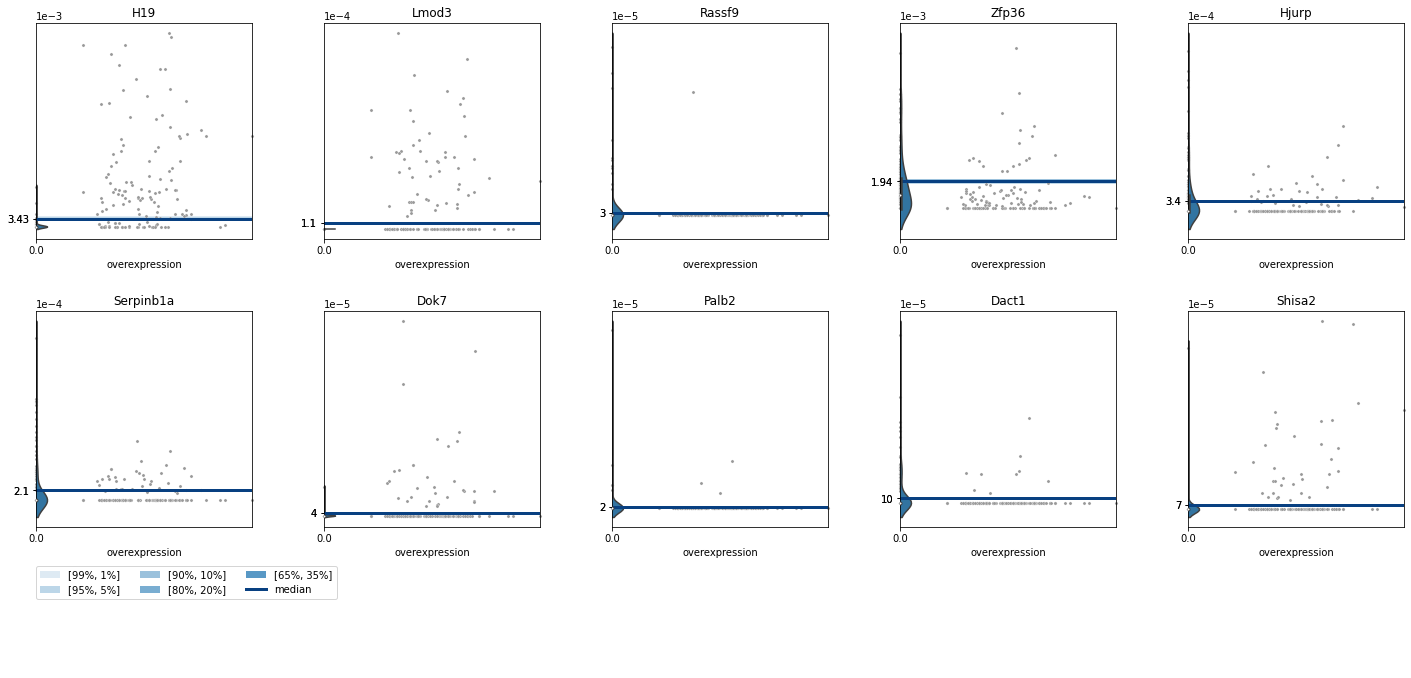

In [207]:
model.overexpression_causal.plot_features();

We can now define our spline and linear models through inheritance, and only change the bits that are different. In this case, this is at the level of model creation:

In [208]:
class LinearModel(ConstantModel):
    default_name = "linear"
    
    def create_root_initial(self, adata):
        root_initial,  = super().create_root_initial(adata)
        
        foldchange = root_initial.find("foldchange")
        overexpression = root_initial.find("overexpression")
        
        foldchange.overexpression = la.links.scalar.Linear(overexpression, a = True, definition=foldchange.value_definition)
        
        return root_initial, 
    
class SplineModel(ConstantModel):
    default_name = "spline"
    
    def create_root_initial(self, adata):
        root_initial,  = super().create_root_initial(adata)
        
        foldchange = root_initial.find("foldchange")
        overexpression = root_initial.find("overexpression")
        
        foldchange.overexpression = la.links.scalar.Spline(overexpression, definition=foldchange.value_definition)
        
        return root_initial, 

In [209]:
model = LinearModel(dataset = dataset)
model.root_initial,  = model.create_root_initial(model.dataset.adata)
model.root, = model.infer_model(model.root_initial)
model.transcriptome_observed, model.overexpression_observed, model.overexpression_causal = model.interpret(model.root)

  0%|                                                                                                         …

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [210]:
model = SplineModel(dataset = dataset)
model.root_initial,  = model.create_root_initial(model.dataset.adata)
model.root, = model.infer_model(model.root_initial)
model.transcriptome_observed, model.overexpression_observed, model.overexpression_causal = model.interpret(model.root)

  0%|                                                                                                         …

/tmp/tmppluw9g_b/linear/root.pkl: 574.1 KiB / 11.3 MiB = 0.050, 0:02
/tmp/tmppluw9g_b/linear/transcriptome_observed.pkl: 4,663.6 KiB / 24.7 MiB = 0.184, 5.6 MiB/s, 0:04
/tmp/tmppluw9g_b/linear/overexpression_causal.pkl: 12.1 MiB / 40.6 MiB = 0.299, 9.0 MiB/s, 0:04


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/tmppluw9g_b/spline/root.pkl: 682.9 KiB / 11.6 MiB = 0.058, 0:02
/tmp/tmppluw9g_b/spline/transcriptome_observed.pkl: 4,848.0 KiB / 25.1 MiB = 0.189, 5.6 MiB/s, 0:04
/tmp/tmppluw9g_b/spline/overexpression_causal.pkl: 12.1 MiB / 40.9 MiB = 0.296, 8.8 MiB/s, 0:04


In [215]:
model

## Building pipelines